# Trabalho Prático 3

## Bruno Jardim (A91680) e José Ferreira(A91636)


> O objetivo deste trabalho é o uso de SMT’s para modelar e verificar propriedades lógicas de sistemas dinâmicos. O trabalho pode ser executado em Z3 , como o seu “wrapper” específico, ou desejavelmente com o “wrapper” PySMT , usando  Z3 e MatSAT e comparando os resultados.


No contexto do sistema de travagem ABS (“Anti-Lock Breaking System”), pretende-se construir um autómato híbrido que descreva o sistema e que  possa ser usado para verificar as suas propriedades dinâmicas.

    
1. A componente discreta do autómato contém os modos:  `Start`,  `Free`,  `Stopping`, `Blocked`, e `Stopped`. No modo `Free`  não existe qualquer força de travagem; no modo `Stopping` aplica-se a força de travagem alta; no modo `Blocked` as rodas estão bloqueadas em relação ao corpo mas o veículo  desloca-se; no modo `Stopped` o veículo está imobilizado.


2. A componente contínua  do autómato usa variáveis contínuas $\,V,v\,$ para descrever a  `velocidade do corpo`  do veículo em relação ao solo e a `velocidade linear das rodas` também em relação ao solo. 
    Assume-se que o sistema de travagem exerce uma força de atrito  nos travões proporcional à diferença das duas velocidades.  A dinâmica contínua está descrita  abaixo no bloco Equaçoes de Fluxo.


3. Os “switchs” (“jumps”) são a componente de projeto deste trabalho; cabe ao aluno definir quais devem ser estas  condições de modo a que o sistema tenha um comportamento desejável: imobilize-se depressa e não “derrape” muito.


4. Faça
    1. Defina um autómato híbrido que descreva a dinâmica do sistema segundo as notas abaixo indicadas e com os “switchs” por si escolhidos.
    2. Modele em lógica temporal linear LT  propriedades que caracterizam o comportamento desejável do sistema. Nomeadamente 
        1. ”o veículo imobiliza-se completamente em menos de $t$ segundos” 
        2. “a velocidade $V$ diminui sempre com o tempo”.
    3. Codifique em SMT’s o modelo que definiu em a.
    4. Codifique a verificação das propriedades temporais que definiu em b.


In [ ]:
import matplotlib.pyplot as plt
def constantes_plot(a, b, c, P, time, v_inicial, epsilon):
    v = v_inicial
    r = v_inicial
    t = 0
    V = [v]
    R = [r]
    T = [t]
    dt = 0.1
    x = 0.3
    timer = 0
    m = "free"
    while(t<time and (v>0 or r>0)):
        if v <= 0.1 :
            m = "stopped"
        print(str(t)+':'+m)
        if timer > x and m== "free":
            c = 2
            m = "stopping"
            timer = 0
        elif m=="stopping" and ( (v - r) <= epsilon or timer > x) :
            c = 0.2
            
            m = "blocked"
            timer = 0
        elif timer >  x and m == "blocked":
            #c = 0.1
            m = "free"
            timer = 0
            var = (-a*P-b)*dt
            v  += var
            r += var
            timer += dt
            t += dt
            V.append(v)
            R.append(r)
            T.append(t)
            continue
        timer += dt
        v,r  = v +(-c*(v-r)-b)*dt, r + (-a*P + c *(v-r))*dt
        t += dt
        V.append(v)
        R.append(r)
        T.append(t)
    m = "stopped"
    plt.plot(T,V,T,R)
constantes_plot(0.01, 2, 0.2, 1500, 20, 27, 0.5)

## Inicialização das variáveis


In [1]:
import matplotlib.pyplot as plt
from z3 import *
Mode, (START,STOPPING,STOPPED,BLOCKED,FREE) = EnumSort('Mode', ('START','STOPPING','STOPPED','BLOCKED','FREE'))

def declare(i):
    state = {}
    state['Vr'] = Real('Vr'+str(i))
    state['Vc'] = Real('Vc'+str(i))
    state['t']  = Real('t' +str(i))
    state['m']  = Const('m'+str(i),Mode)
    state['timer'] = Real('timer'+str(i))
    return state

## Transições

Para assegurar o comportamento desejado do sistema ABS definimos as seguintes transições, visíveis no seguinte autómato:
### Untimed
>`Start` $\rightarrow$ `Free` 
$\newline$ `Stopping` $\rightarrow$ `Stopped`
$\newline$ `Free` $\rightarrow$ `Stopped`
$\newline$ `Blocked` $\rightarrow$ `Stopped`
$\newline$ `Free` $\rightarrow$ `Stopping`
$\newline$ `Stopping` $\rightarrow$ `Blocked`
$\newline$ `Blocked` $\rightarrow$ `Free`
### Timed
>`Free` $\rightarrow$ `Free`
$\newline$ `Stopping` $\rightarrow$ `Stopping`
$\newline$ `Blocked` $\rightarrow$ `Blocked`
$\newline$ `Stopped` $\rightarrow$ `Stopped`

![title](automato.png)



In [42]:

a, b, c1,c2, P, tau,intervalo = 0.01, 0.5, 0.5,10, 1000, 0.1,0.1

def init(s, v_input, a, b, c): 
  #t -> tempo, m-> modo, v-> velocidade rodas, V -> velocidade corpo
  return And(s['t'] == 0, s['m'] == START, s['Vr'] == v_input, s['Vc'] == v_input)

def trans(s, p): 
  #untimed 
    #alwayspositive = And(s['Vr']>=0,s['Vc']>=0)
    #nextpositive = And(p['Vr']>=0,p['Vc']>=0)
    #limite    = And(s['Vr']<=s['Vc'])
    #limsup    = And(s['Vr']<=s['Vc'],p['Vr']<=p['Vc'])
    #alwaysdecrease = And(s['Vr']>p['Vr'],s['Vc']>p['Vc'])
    #blockspeed = And(p['Vc']<=0.1,s['Vr']<=0.1)
    #stoplim = And(p['Vr']-s['Vr']<=3)
    
    stopping_stopped = And( s['t']  == p['t'],  
                            s['m']  == STOPPING, 
                            p['m']  == STOPPED, 
                            s['Vc'] <= 0.1,
                            s['Vr'] <= 0.1,
                            p['Vc'] == 0,
                            p['Vr'] == 0,
                            p['timer'] == 0
                          )
    
    free_stopped    =  And( s['t'] == p['t'],   
                            s['m'] == FREE,       
                            p['m'] == STOPPED, 
                            s['Vc'] <= 0.1,
                            s['Vr'] <= 0.1,
                            p['Vc'] == 0,
                            p['Vr'] == 0,
                            p['timer'] == 0
                          )
    
    start_free       = And( s['t'] == p['t'], 
                            s['Vr'] == p['Vr'],
                            s['Vc'] == p['Vc'], 
                            s['m'] == START, 
                            p['m'] == FREE,
                            s['timer'] == 0,
                            p['timer'] == 0 )

    free_stopping    = And( s['t'] == p['t'], 
                            s['Vr'] == p['Vr'], 
                            s['Vc'] == p['Vc'],
                            s['m'] == FREE, 
                            p['m'] == STOPPING,  
                            p['timer']==0,
                            #s['Vc'] >  0,
                            s['Vr'] > 0.1,
                            Or(s['timer']>=tau,s['Vc'] - s['Vr']>=0.1)
                          ) 
 
    stopping_blocked = And( s['t'] == p['t'], 
                            s['Vr'] == p['Vr'], 
                            s['Vc'] == p['Vc'], 
                            s['m'] == STOPPING, 
                            p['m'] == BLOCKED, 
                            s['Vc'] < s['Vr'] + 0.2,
                            s['timer'] == 0,
                            p['timer'] == 0,
                            #s['Vc'] > 0,
                            s['Vr'] > 0.1
                          )
    
    blocked_stopped = And(  s['t'] == p['t'],  
                            s['m'] == BLOCKED, 
                            p['m'] == STOPPED,
                            #s['timer'] == 0,
                            s['Vc'] <= 0.1,
                            s['Vr'] <= 0.1,
                            p['Vc'] == 0,
                            p['Vr'] == 0,
                            p['timer'] == 0
                         )

    blocked_free     = And( s['t'] == p['t'], 
                            s['Vr'] == p['Vr'], 
                            s['Vc'] == p['Vc'], 
                            s['m'] == BLOCKED, 
                            p['m'] == FREE, 
                            s['timer']>=tau, 
                            p['timer']==0,
                            #s['Vc'] > 0,
                            s['Vr'] > 0.1
                          ) 

   
   
    
    
  

  #timed 

    free_free = And(s['m'] == FREE, 
                    p['m'] == FREE, 
                    p['Vc']   == s['Vc'] +   (-c1 * (s['Vc'] - s['Vr']) -b) * intervalo, 
                    p['Vr']   == s['Vr'] +   (-a * P + c1 * (s['Vc'] - s['Vr'])) * intervalo, 
                    p['t'] == s['t']+intervalo, 
                    #p['Vc'] + 1 >= s['Vc'], 
                    p['timer']==s['timer']+intervalo,
                    #p['Vc'] >=0,
                    
                    p['timer']<=tau,
                    s['Vr'] > 0.1,
                    #alwaysdecrease,
                    #stoplim
                   )
                    #alwaysdecrease,
                    #limsup,
                    #limite,
                    #alwayspositive 

    stopping_stopping = And(s['m'] == STOPPING, p['m'] == STOPPING, 
                            p['Vc']   == s['Vc'] +   (-c2 * (s['Vc'] - s['Vr']) - b) * intervalo, 
                            p['Vr']   == s['Vr'] +   (-a * P + c2 * (s['Vc'] - s['Vr'])) * intervalo,
                            s['Vc'] > s['Vr'] + 0.2,
                            p['t'] == s['t']+intervalo,
                            s['timer'] == p['timer'],
                            #p['Vc']>0.1,
                            #alwaysdecrease,
                            #stoplim
                           )
                            #limsup,
                            #limite,
                            #alwayspositive
    
    blocked_blocked = And(s['m'] == BLOCKED, p['m'] == BLOCKED, 
                          
                          p['Vc']   == s['Vc'] + (-a*P-b)*intervalo, 
                          p['Vr']   == s['Vr'] + (-a*P-b)*intervalo, 
                          p['t'] == s['t']+intervalo,
                          p['timer']==s['timer']+intervalo,
                          #p['Vc']>0.1,
                          p['timer']<=tau,
                          #p['Vc'] <= p['Vr']+0.2,
                          #limite,
                          #limsup,
                          #alwayspositive,
                          #alwaysdecrease
                         )
    
    stopped_stopped = And(s['m'] == STOPPED, 
                          p['m'] == STOPPED, 
                          p['t'] == s['t']+intervalo,
                          s['timer'] == 0,
                          p['timer'] == 0,
                          s['Vr'] == p['Vr'],
                          s['Vc'] == p['Vc'])
                          #limite,
                          #alwayspositive,
                          #blockspeed
  
    return Or( stopping_blocked,stopping_stopped,free_stopped, blocked_stopped,start_free, free_stopping, blocked_free, free_free, stopping_stopping,blocked_blocked,stopped_stopped)





In [43]:
def frac2float(x):
    #print(x)
    return float(x.numerator_as_long())/float(x.denominator_as_long())
def gera_traco(declare, init, trans, k):
    T=[]
    VV=[]
    VR=[]
    s = Solver()
    traco = [declare(i) for i in range(k)]

    s.add(init(traco[0], 27,0.01,0.1,0.5))
    
    for i in range(k-1):
        s.add(trans(traco[i], traco[i+1]))
        
    #s.add(traco[k-1]['m'] == STOPPED) toma carrico
    
    if s.check() == sat:
        m = s.model()
        
        T  = [frac2float(m[traco[i]["t"]] ) for i in range(k)]  
        VV = [frac2float(m[traco[i]["Vc"]]) for i in range(k)]         
        VR = [frac2float(m[traco[i]["Vr"]]) for i in range(k)]
        for i in range(k):
            print("Estado:", i)
            for v in traco[i]:
                
                res = m[traco[i][v]]
                #print(res)
                
                    
                
                
                if res.sort() != RealSort():
                    print(v, '=', res)
                else:
                    print(v, '=', float(res.numerator_as_long())/float(res.denominator_as_long()))
            print()
    else:
        print("Não tem solução.")
    plt.plot(T, VV, T, VR)


Estado: 0
Vr = 27.0
Vc = 27.0
t = 0.0
m = START
timer = 0.0

Estado: 1
Vr = 27.0
Vc = 27.0
t = 0.0
m = FREE
timer = 0.0

Estado: 2
Vr = 26.0
Vc = 26.95
t = 0.1
m = FREE
timer = 0.1

Estado: 3
Vr = 26.0
Vc = 26.95
t = 0.1
m = STOPPING
timer = 0.0

Estado: 4
Vr = 25.95
Vc = 25.95
t = 0.2
m = STOPPING
timer = 0.0

Estado: 5
Vr = 25.95
Vc = 25.95
t = 0.2
m = BLOCKED
timer = 0.0

Estado: 6
Vr = 24.9
Vc = 24.9
t = 0.3
m = BLOCKED
timer = 0.1

Estado: 7
Vr = 24.9
Vc = 24.9
t = 0.3
m = FREE
timer = 0.0

Estado: 8
Vr = 23.9
Vc = 24.85
t = 0.4
m = FREE
timer = 0.1

Estado: 9
Vr = 23.9
Vc = 24.85
t = 0.4
m = STOPPING
timer = 0.0

Estado: 10
Vr = 23.85
Vc = 23.85
t = 0.5
m = STOPPING
timer = 0.0

Estado: 11
Vr = 23.85
Vc = 23.85
t = 0.5
m = BLOCKED
timer = 0.0

Estado: 12
Vr = 22.8
Vc = 22.8
t = 0.6
m = BLOCKED
timer = 0.1

Estado: 13
Vr = 22.8
Vc = 22.8
t = 0.6
m = FREE
timer = 0.0

Estado: 14
Vr = 21.8
Vc = 22.75
t = 0.7
m = FREE
timer = 0.1

Estado: 15
Vr = 21.8
Vc = 22.75
t = 0.7
m = STOPPING


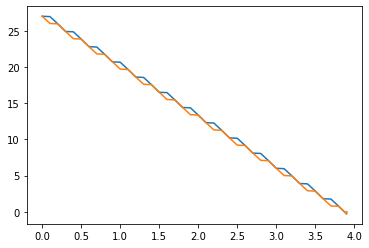

In [45]:
gera_traco(declare, init, trans,80)

## Propriedades
De seguida encontram-se a definição das seguintes propriedades
  1. ”o veículo imobiliza-se completamente em menos de $t$ segundos” 
  2. “a velocidade $V$ diminui sempre com o tempo”.

In [61]:
def imobXSec(state):
    return Implies(state['t']>=4,state['m']==STOPPED)
def sempreMenor(atual,prox):
    return Implies(And(atual['m']==STOPPED,atual['t']<prox['t']),atual['Vc']>prox['Vc'])

In [64]:
def testaImob(declare,init,trans,inv,K):
    for k in range(1,K+1):
        s = Solver()
        
        trace = [declare(i) for i in range(k)]
        
        s.add(init(trace[0],27,0.01,0.1,0.5))
        for i in range(k-1):
            s.add(trans(trace[i],trace[i+1]))
        
        s.add(Not(inv(trace[k-1])))
        
        if s.check() == sat:
            m = s.model()
            for i in range(k):
                for v in trace[i]:
                    print(i,v,'=',m[trace[i][v]])
            return

    print ("Property MAY be valid")

In [65]:
testaImob(declare,init,trans,imobXSec,50)

Property MAY be valid


In [66]:
def testaMenor(declare,init,trans,inv,K):
    for k in range(1,K+1):
        s = Solver()
        
        trace = [declare(i) for i in range(k)]
        
        s.add(init(trace[0],27,0.01,0.1,0.5))
        aux=[]
        for i in range(k-1):
            s.add(trans(trace[i],trace[i+1]))
            aux.append(Not(inv(trace[i],trace[i+1])))
        
        s.add(Or(aux))
        
        if s.check() == sat:
            m = s.model()
            for i in range(k):
                for v in trace[i]:
                    print(i,v,'=',m[trace[i][v]])
            return

    print ("Property MAY be valid")

In [67]:
testaMenor(declare,init,trans,sempreMenor,20)

Property MAY be valid
